In [1]:
# Download the challenge set files
from pycbc.frame import read_frame
import pylab
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
%matplotlib inline

# An example of how to read the data from these files:
file_name = "challenge2.gwf"

# LOSC bulk data typically uses the same convention for internal channels names
# Strain is typically IFO:LOSC-STRAIN, where IFO can be H1/L1/V1.
channel_name = "H1:CHALLENGE2"


ts = read_frame(file_name, channel_name)

In [2]:
ts.duration

128.0

In [3]:
ts.sample_rate

4096.0

In [4]:
strain = highpass(ts, 15.0)
strain = resample_to_delta_t(strain, 1.0/4096.0)
conditioned = strain.crop(2, 2)

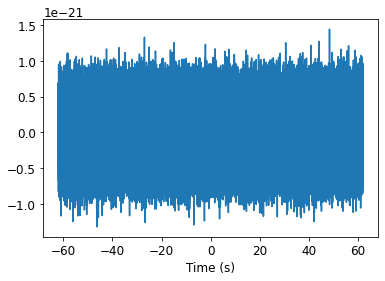

In [5]:
pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

In [6]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

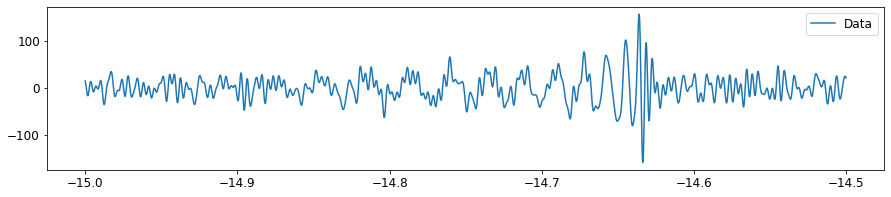

In [12]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
#white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
#white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(-15,-14.5)
#white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
#pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

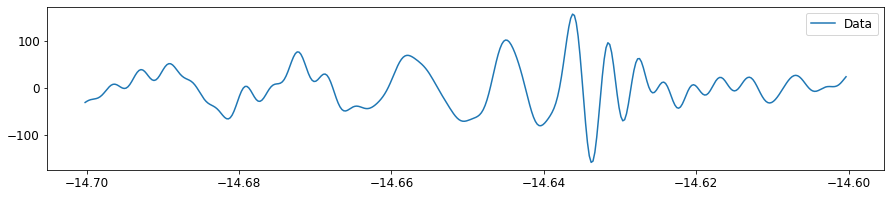

In [14]:
white_data = white_data.time_slice(-14.7,-14.6)
#white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
#pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

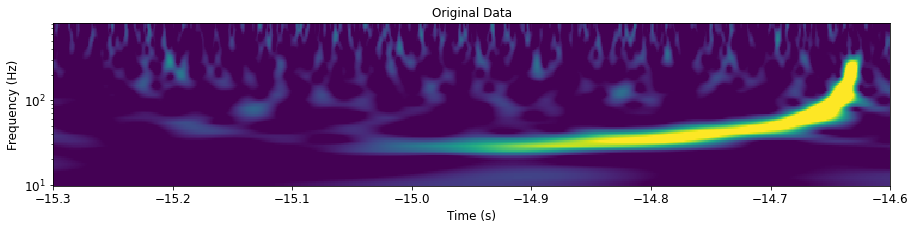

In [22]:
for data, title in [(conditioned, 'Original Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001, logfsteps=100, qrange=(8, 8), frange=(10, 800))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6, shading='auto')
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(-15.3,-14.6)
    pylab.show()

In [23]:
from pycbc.waveform import get_td_waveform

m = 30 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",   # spin is set to 0 by default
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# Resize the vector to match our data
hp.resize(len(conditioned))

In [24]:
#conditioned.delta_t

0.000244140625

In [25]:
template = hp.cyclic_time_shift(hp.start_time)

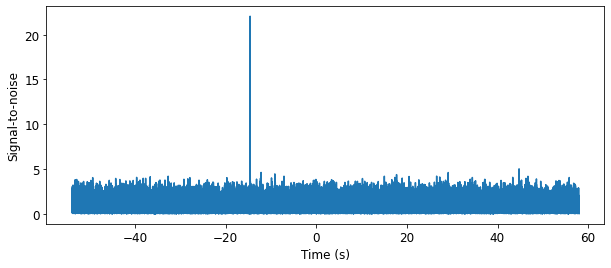

We found a signal at -14.6328125s with SNR 22.05517500740431


In [26]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seconds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why are we taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))